# A/B Testing Project


# Description

**An international online store looking to boost their conversion rate on each stage of the funnel. In order to achive that goal, the store came up with an idea for a new improved recommendation system, and expected at least 10% rise in each stage of the funnel. <br>
In order to examine the affect of the change, they have performed an A/B test, dividing the users into two groups. A - control group that see the old design, and B - group that have encountered the changes.**

## Read the data files and study the general information. 

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [71]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv',
                            parse_dates = ['start_dt', 'finish_dt'])
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv',
                            parse_dates = ['first_date'])
user_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv',
                            parse_dates = ['event_dt'])
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [77]:
df = user_events[user_events['event_name'] == 'purchase']
df = df.drop(['event_name'], axis = 1)
df

,user_id,event_dt,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,4.99
3,96F27A054B191457,2020-12-07 04:02:40,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,4.99
...,...,...,...
60309,1455450835F72F5E,2020-12-30 09:27:10,4.99
60310,339C4C55021A83C6,2020-12-30 12:55:08,9.99
60311,D1553B56FFA8974B,2020-12-30 03:15:35,4.99
60312,245E85F65C358E08,2020-12-30 19:35:55,9.99


In [72]:
def column_change(df, placed_column, replaced_column):
    temp = df[replaced_column].copy()
    df[replaced_column] = df[placed_column]
    df[placed_column] = temp
    df.rename(columns = {placed_column:'temp'}, inplace = True)
    df.rename(columns = {replaced_column:placed_column}, inplace = True)
    df.rename(columns = {'temp':replaced_column}, inplace = True)

In [15]:
marketing_events.info()
print('')
print('Number of duplicated values: ',marketing_events.duplicated().sum())
print('Number of missing values: ')
print(marketing_events.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

Number of duplicated values:  0
Number of missing values: 
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [16]:
users.info()
print('')
print('Number of duplicated values: ',users.duplicated().sum())
print('Number of missing values: ')
print(users.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB

Number of duplicated values:  0
Number of missing values: 
user_id       0
first_date    0
region        0
device        0
dtype: int64


In [17]:
user_events.info()
print('')
print('Number of duplicated values: ',user_events.duplicated().sum())
print('Number of missing values: ')
print(user_events.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB

Number of duplicated values:  0
Number of missing values: 
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


In [18]:
participants.info()
print('')
print('Number of duplicated values: ',participants.duplicated().sum())
print('Number of missing values: ')
print(participants.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

Number of duplicated values:  0
Number of missing values: 
user_id    0
group      0
ab_test    0
dtype: int64


**Read the csv file with date columns as datetime type.<br>
We have missing values at the details column, for events that didn't make revenue directly (product page, product cart and login). <br>
We don't have any duplicated rows in any df.**

## Preprocess the data

**In the preprocess stage, I was trying to gather the expected of test participants - around 6000.
In the participants df, we only have around 3600 user IDs specifically gathered for the "recommender_system_test". In order to gather enough participants to our A/B test, I had to also use data on users dedicated to the "interface_eu_test". assuming in both tests the participants in each group A/B have seen the exact interface in the defined period of time.**

In [19]:
good_users = participants.merge(users, on = 'user_id').query('(first_date >= "2020-12-07") & (first_date <= "2020-12-21") & region == "EU"')

good_users_funnel = user_events.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_dt', aggfunc = 'min').reset_index()

good_users_funnel = good_users_funnel.merge(good_users, on = 'user_id')

good_users_funnel.dropna(subset = ['login'], inplace = True)

**Merging the participants and users dfs on user_id, while making sure all the users are from EU region and made their first sign up after the launch and before the end date.<br>
Then creating the funnel df for each user and merging again on user_id, so we have only user_ids that are fit to our conditions.<br>
Dropping rows with null values in the 'login' column.**

**Ended up with around 13,000 users, but there were problems with the data. In a lot of cases the time of an event didn't match with the time of the following event, events that apparently happend before the next stage in the funnel. <br>
For example a funnel of product_cart -> product_page -> purchase, with product page that comes only after the product cart, Or purchases that were made without visiting the product page or putting the product in the cart (product page and cart are NaT values).
I can't tell why these problems occured and I will ask the data engineers, but for now all I can do is making sure the funnel makes sence.**

**I will assume the first example was technical mistake, so I will drop the H:M:S part of the date and only deal with the days, while making sure the events occured according to the funnel.**

In [ ]:
new_df[group + '_' + stages[i] + '_sum_' + 'cumulative'] = new_df[group + '_' + df].cumsum(axis = 0)       

In [9]:
good_users_funnel['login'] = good_users_funnel['login'].dt.date
good_users_funnel['product_page'] = good_users_funnel['product_page'].dt.date
good_users_funnel['product_cart'] = good_users_funnel['product_cart'].dt.date
good_users_funnel['purchase'] = good_users_funnel['purchase'].dt.date

good_users_funnel['login'] = pd.to_datetime(good_users_funnel['login'])
good_users_funnel['product_page'] = pd.to_datetime(good_users_funnel['product_page'])
good_users_funnel['product_cart'] = pd.to_datetime(good_users_funnel['product_cart'])
good_users_funnel['purchase'] = pd.to_datetime(good_users_funnel['purchase'])

In [10]:
login_only = good_users_funnel[(good_users_funnel['login'].notna()) &
                              (good_users_funnel['product_page'].isna()) &
                              (good_users_funnel['product_cart'].isna()) &
                              (good_users_funnel['purchase'].isna())]

login_page = good_users_funnel[(good_users_funnel['login'].notna()) &
                              (good_users_funnel['product_page'].notna()) &
                              (good_users_funnel['product_cart'].isna()) &
                              (good_users_funnel['purchase'].isna()) &
                              (good_users_funnel['login'] <= good_users_funnel['product_page'])]

login_page_cart = good_users_funnel[(good_users_funnel['login'].notna()) &
                                   (good_users_funnel['product_page'].notna()) &
                                   (good_users_funnel['product_cart'].notna()) &
                                   (good_users_funnel['purchase'].isna()) &
                                   (good_users_funnel['login'] <= good_users_funnel['product_page']) &
                                   (good_users_funnel['product_page'] <= good_users_funnel['product_cart'])]

login_page_cart_purchase = good_users_funnel[(good_users_funnel['login'].notna()) &
                                            (good_users_funnel['product_page'].notna()) &
                                            (good_users_funnel['product_cart'].notna()) &
                                            (good_users_funnel['purchase'].notna()) &
                                            (good_users_funnel['login'] <= good_users_funnel['product_page']) &
                                            (good_users_funnel['product_page'] <= good_users_funnel['product_cart']) &
                                            (good_users_funnel['product_cart'] <= good_users_funnel['purchase'])]

**Made sure the event's dates makes sence and there are no events with null values that have actual events after them.**

In [11]:
good_funnel = login_only.append(login_page).append(login_page_cart).append(login_page_cart_purchase).reset_index(drop = True)
column_change(good_funnel, 'product_cart', 'product_page')

good_funnel.drop(['ab_test', 'first_date', 'region'], axis = 1, inplace = True)

**Ended up with 4 dfs, each represents different final stage in the funnel:<br>**
**1) for participants that only logged in** <br>
**2) login -> product_page<br>**
**3) login -> product_page -> product_cart<br>**
**4) login -> product_page -> product_cart -> purchase<br>**

In [12]:
purchases = pd.DataFrame(data = user_events[user_events['event_name'] == 'purchase'])
purchases['event_dt'] = purchases['event_dt'].dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

In [13]:
good_funnel = pd.merge(good_funnel, purchases,  how='left', left_on=['user_id','purchase'], right_on = ['user_id','event_dt']).drop(['event_dt', 'event_name'], axis = 1)

good_funnel = good_funnel.sort_values(by = 'product_page', ascending = True).reset_index(drop = True)

**Added the details colums so I will know the revenue for each user that ended up purchasing.**

In [14]:
all_duplicates = good_funnel[good_funnel['user_id'].duplicated(keep = False) == True]

In [15]:
a_b_check = pd.DataFrame(data = all_duplicates.groupby('user_id')['group'].value_counts())

In [16]:
a_b_check.head()

group
user_id          group       
001064FEAAB631A1 B          2
00341D8401F0F665 A          2
0082295A41A867B5 A          1
                 B          1
00E68F103C66C1F7 A          1

**While looking for duplicated users, found some users who are in both A and B groups.<br>
These kind of users need to be dropped completely since we don't know in which group they were.<br>
For users that had duplicates only in one group, we can just use drop_duplicates.**

In [17]:
double_users = a_b_check[a_b_check['group'] < 2]

In [18]:
double_users = double_users.index.get_level_values('user_id')

In [19]:
good_funnel = good_funnel[~good_funnel['user_id'].isin(double_users)].reset_index()

In [20]:
good_funnel['user_id'].duplicated().sum()

283

In [21]:
good_funnel.drop_duplicates(subset = 'user_id', inplace = True)

In [22]:
a_group = good_funnel[good_funnel['group'] == 'A']
b_group = good_funnel[good_funnel['group'] == 'B']

**Eventually, I ended up with around 8000 participants, let's divide them by group and see if we can take two samples with total of around 6000 participants.**

In [23]:
print('Number of A group participants: ',len(a_group))
print('Number of B group participants: ',len(b_group))

Number of A group participants:  4453
Number of B group participants:  3445


**We can create two samples with 2500 participants in each group with total of 5000 participants.**

In [24]:
a_sample = a_group.sample(n = 3000, random_state = 0).reset_index(drop = True)
b_sample = b_group.sample(n = 3000, random_state = 0).reset_index(drop = True)

**After filtering the users and creating 2 groups we can start carrying exploratory data analysis.**

## EDA

**I want to study the cumulative values of each step according to date. I will create two dfs, one for each group, and use them to compare the cumulative values in each day.**

In [25]:
def cumulative(sample, group):
    cumulative_df = pd.DataFrame(data = a_sample['login'].unique())
    cumulative_df = cumulative_df.rename({0: 'date'}, axis = 1).sort_values(by = 'date').reset_index(drop = True)
    
    stages = ['login', 'product_page', 'product_cart', 'purchase', 'purchase']
    dfs = ['login_count', 'page_count', 'cart_count', 'purchase_count', 'purchase_sum']
    i = 0
    
    for df in dfs:
        if  df != 'purchase_sum':
            new_df = sample.groupby(stages[i])['device'].count().reset_index()
            new_df = new_df.rename({stages[i]: 'date', 'device': group + '_' + df}, axis = 1)
            new_df[group + '_' + stages[i] + '_' + 'cumulative'] = new_df[group + '_' + df].cumsum(axis = 0)
            
        else: 
            new_df = sample.groupby(stages[i])['details'].sum().reset_index()
            new_df = new_df.rename({stages[i]: 'date', 'details': group + '_' + df}, axis = 1)
            new_df[group + '_' + stages[i] + '_sum_' + 'cumulative'] = new_df[group + '_' + df].cumsum(axis = 0)
            
        cumulative_df = cumulative_df.merge(new_df, on = 'date')
        i = i + 1
    
    cumulative_df[group + '_avg_purchase_size'] = cumulative_df[group + '_purchase_sum'] / cumulative_df[group + '_purchase_count']
    cumulative_df[group + '_login_page_conversion'] = (cumulative_df[group + '_page_count'] / cumulative_df[group + '_login_count']) * 100
    cumulative_df[group + '_page_cart_conversion'] = (cumulative_df[group + '_cart_count'] / cumulative_df[group + '_page_count']) * 100
    cumulative_df[group + '_cart_purchase_conversion'] = (cumulative_df[group + '_purchase_count'] / cumulative_df[group + '_cart_count']) * 100
    cumulative_df[group + '_daily_events'] = cumulative_df[group + '_login_count'] + cumulative_df[group + '_page_count'] + cumulative_df[group + '_cart_count'] + cumulative_df[group + '_purchase_count']
    cumulative_df[group + '_daily_events_per_user'] = cumulative_df[group + '_daily_events'] / cumulative_df[group + '_login_count']
    return cumulative_df

In [26]:
def cumulative(sample, group):
    cumulative_df = pd.DataFrame(data = a_sample['login'].unique())
    cumulative_df = cumulative_df.rename({0: 'date'}, axis = 1).sort_values(by = 'date').reset_index(drop = True)
    
    stages = ['login', 'product_page', 'product_cart', 'purchase', 'purchase']
    dfs = ['login_count', 'page_count', 'cart_count', 'purchase_count', 'purchase_sum']
    i = 0
    
    for df in dfs:
        if  df != 'purchase_sum':
            new_df = sample.groupby(stages[i])['device'].count().reset_index()
            new_df = new_df.rename({stages[i]: 'date', 'device': group + '_' + df}, axis = 1)
            new_df[group + '_' + stages[i] + '_' + 'cumulative'] = new_df[group + '_' + df].cumsum(axis = 0)
            
        else: 
            new_df = sample.groupby(stages[i])['details'].sum().reset_index()
            new_df = new_df.rename({stages[i]: 'date', 'details': group + '_' + df}, axis = 1)
            new_df[group + '_' + stages[i] + '_sum_' + 'cumulative'] = new_df[group + '_' + df].cumsum(axis = 0)
            
        cumulative_df = cumulative_df.merge(new_df, on = 'date')
        i = i + 1
    
    cumulative_df[group + '_avg_purchase_size'] = cumulative_df[group + '_purchase_sum'] / cumulative_df[group + '_purchase_count']
    cumulative_df[group + '_login_page_conversion'] = (cumulative_df[group + '_product_page_cumulative'] / cumulative_df[group + '_login_cumulative']) * 100
    cumulative_df[group + '_page_cart_conversion'] = (cumulative_df[group + '_product_cart_cumulative'] / cumulative_df[group + '_product_page_cumulative']) * 100
    cumulative_df[group + '_cart_purchase_conversion'] = (cumulative_df[group + '_purchase_cumulative'] / cumulative_df[group + '_product_cart_cumulative']) * 100
    cumulative_df[group + '_daily_events'] = cumulative_df[group + '_login_count'] + cumulative_df[group + '_page_count'] + cumulative_df[group + '_cart_count'] + cumulative_df[group + '_purchase_count']
    cumulative_df[group + '_cumulative_daily_events'] = cumulative_df[group + '_daily_events'].cumsum(axis = 0)
    cumulative_df[group + '_daily_events_per_user'] = cumulative_df[group + '_daily_events'] / cumulative_df[group + '_login_count']
    cumulative_df[group + '_cumulative_daily_events_per_user'] = cumulative_df[group + '_daily_events_per_user'].cumsum(axis = 0)

    return cumulative_df

In [27]:
a_cumulative = cumulative(a_sample, 'a')
b_cumulative = cumulative(b_sample, 'b')

In [28]:
def plot(title, xlabel, ylabel, i):
    
    plots = ['login_page_conversion', 'page_cart_conversion',
         'cart_purchase_conversion', 'cumulative_daily_events_per_user',
         'cumulative_daily_events', 'purchase_sum_cumulative', 'avg_purchase_size']
    
    ax = a_cumulative.plot(x = 'date', y = 'a_' + plots[i], figsize=(17,9), label = 'group A')
    b_cumulative.plot(x = 'date', y = 'b_' + plots[i], figsize=(17,9), ax = ax, label = 'group B')
    plt.title(title, fontsize = 15)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(prop={'size': 15})
    plt.grid()

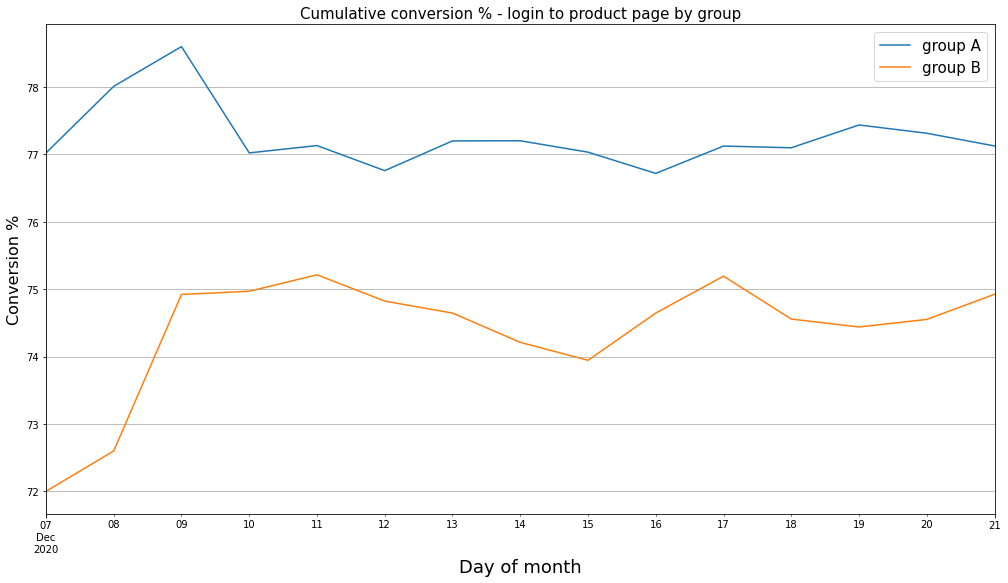

In [29]:
plot('Cumulative conversion % - login to product page by group', 'Day of month', 'Conversion %', 0)

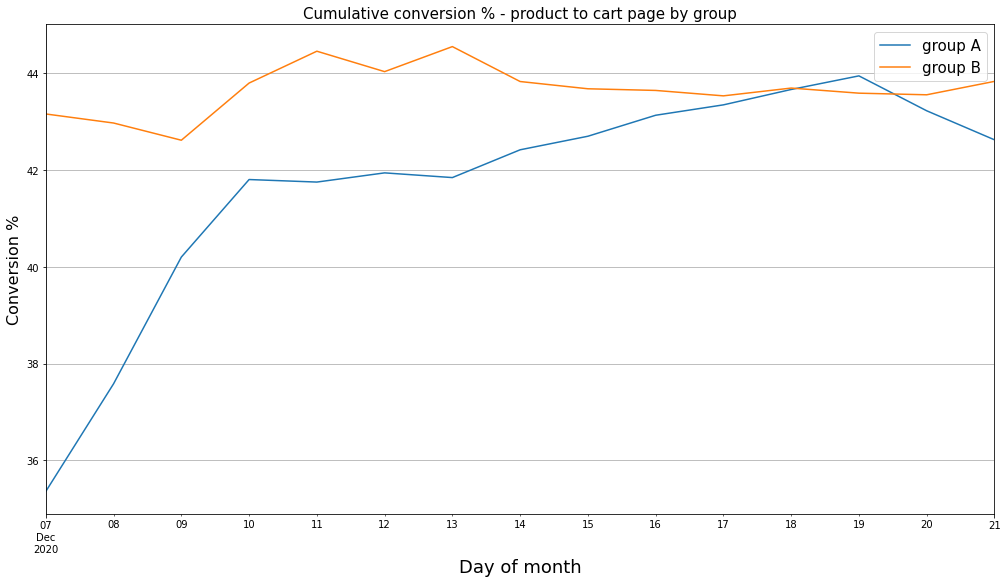

In [30]:
plot('Cumulative conversion % - product to cart page by group', 'Day of month', 'Conversion %', 1)

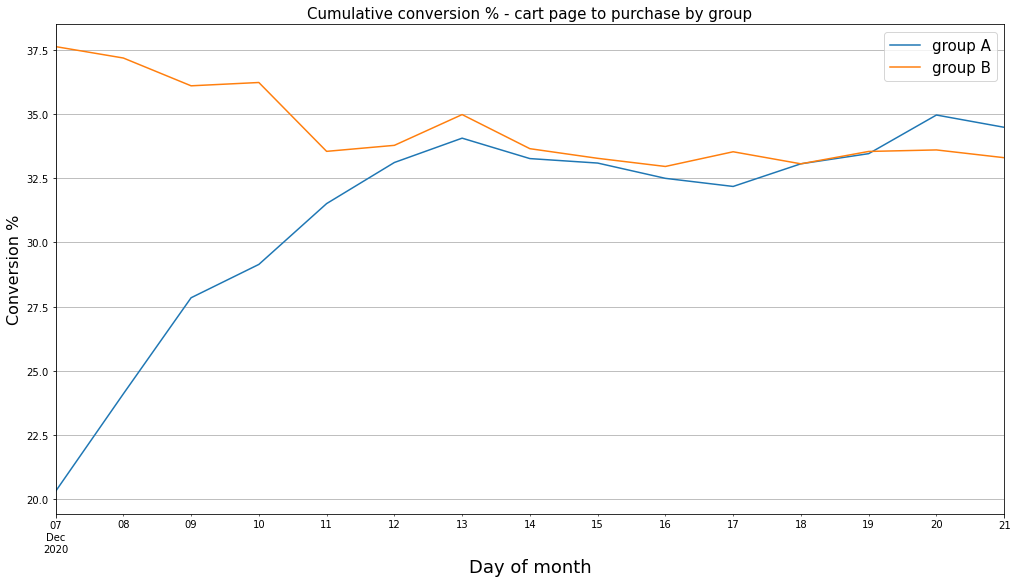

In [31]:
plot('Cumulative conversion % - cart page to purchase by group', 'Day of month', 'Conversion %', 2)

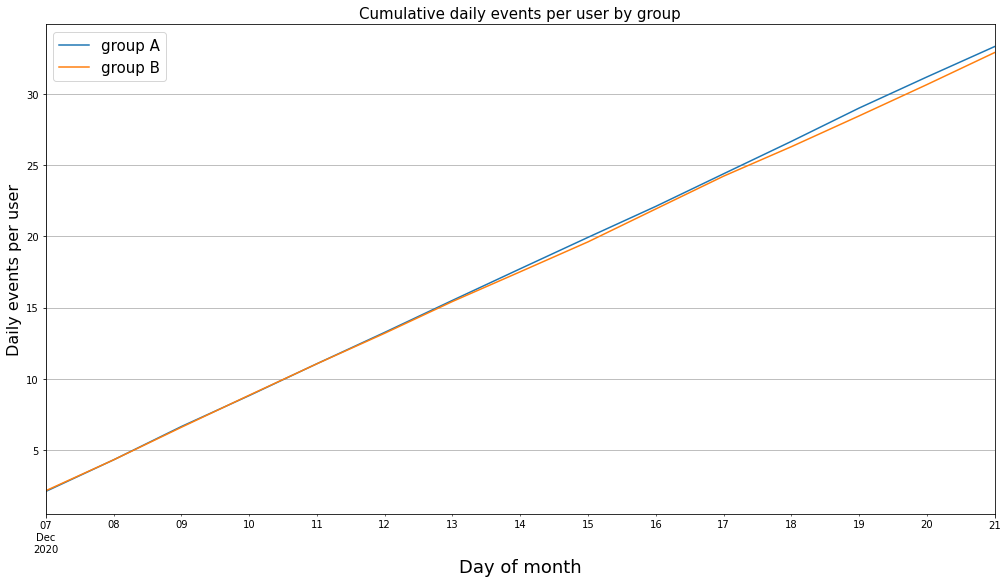

In [32]:
plot('Cumulative daily events per user by group', 'Day of month', 'Daily events per user', 3)

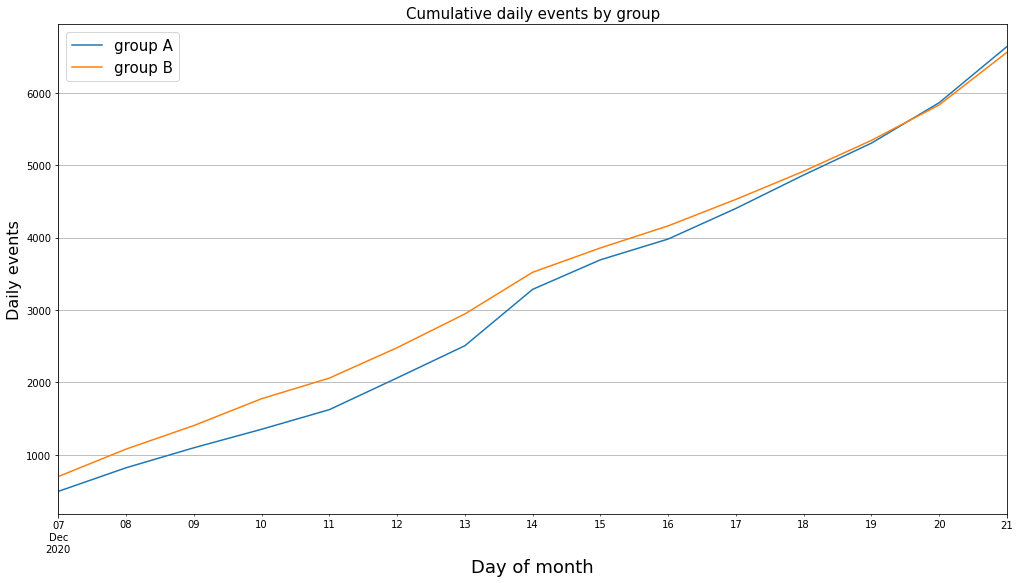

In [33]:
plot('Cumulative daily events by group', 'Day of month', 'Daily events', 4)

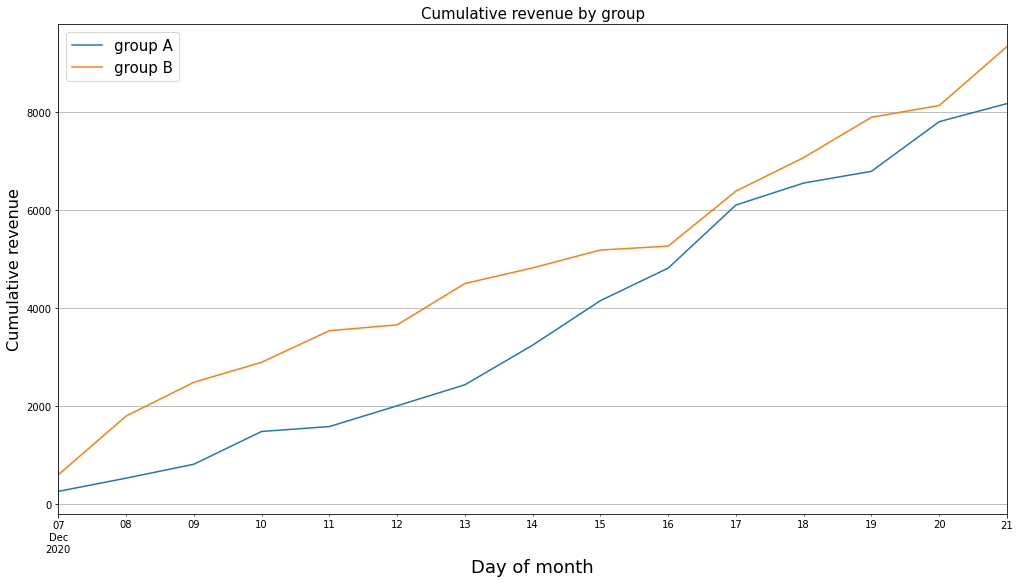

In [34]:
plot('Cumulative revenue by group', 'Day of month', 'Cumulative revenue', 5)

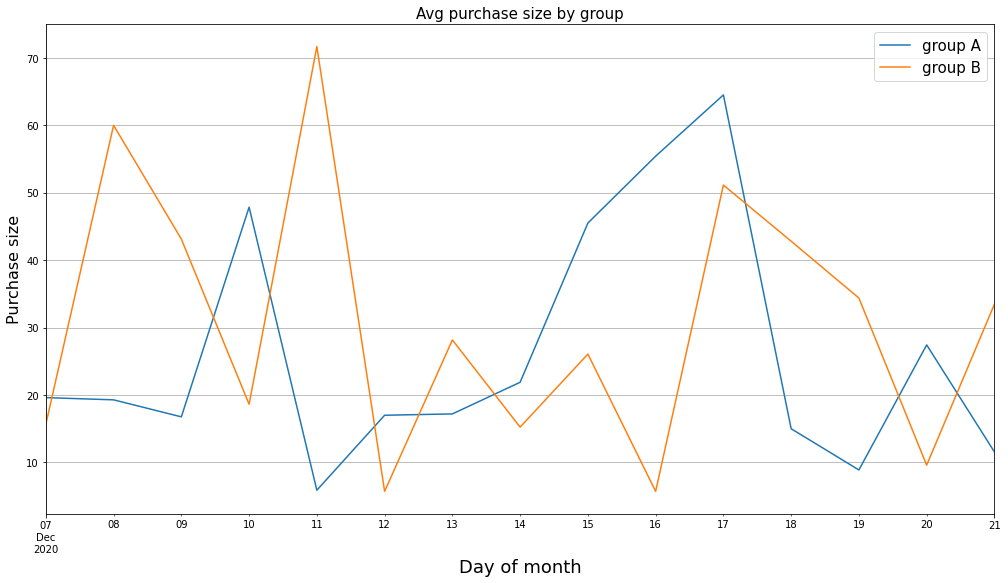

In [35]:
plot('Avg purchase size by group', 'Day of month', 'Purchase size', 6)

**We don't have definite advantage for any of the groups. Group A might have slight advantage in the conversion of the first stage, but the adavantage is not significant and we can't say one of the groups performed better than the other. Looks like the change in recommendation system didn't affect much.**

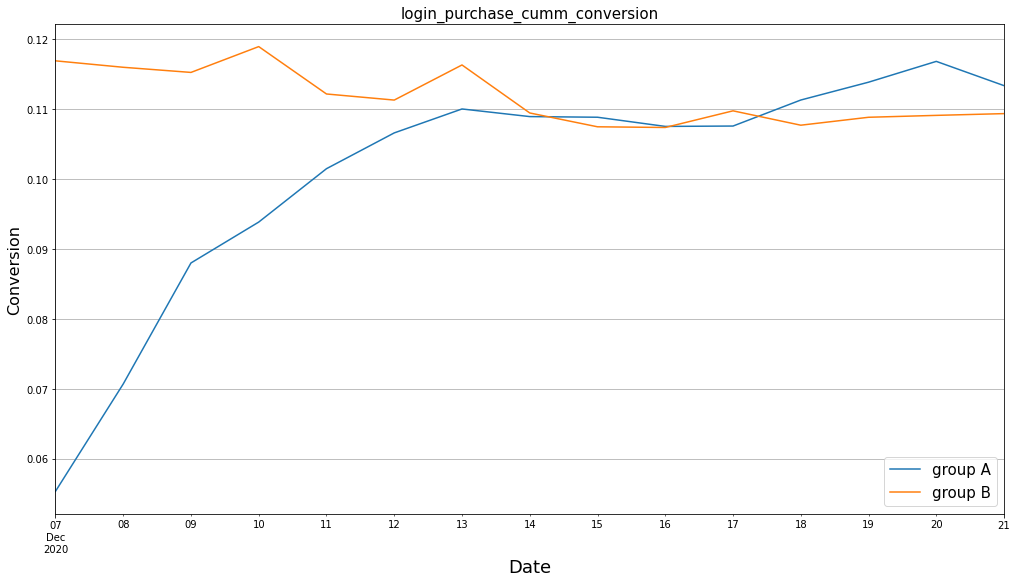

In [36]:
# the reviewer's cell:
tmp_a = a_cumulative.copy()
tmp_b = b_cumulative.copy()

tmp_a['a_login_purchase_cumm_conversion'] =  tmp_a['a_purchase_cumulative']/tmp_a['a_login_cumulative']
tmp_b['b_login_purchase_cumm_conversion'] =  tmp_b['b_purchase_cumulative']/tmp_b['b_login_cumulative']

ax = tmp_a.plot(x = 'date', y = 'a_login_purchase_cumm_conversion', figsize=(17,9), label = 'group A')
tmp_b.plot(x = 'date', y = 'b_login_purchase_cumm_conversion', figsize=(17,9), ax = ax, label = 'group B')

plt.title('login_purchase_cumm_conversion', fontsize = 15)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Conversion', fontsize=16)
plt.legend(prop={'size': 15})
plt.grid()

**Let's look at the relative difference in conversion % and see if we can conclude something from it.**

In [37]:
merged_cum_conversions = a_cumulative[['date','a_login_page_conversion',
                                       'a_page_cart_conversion',
                                       'a_cart_purchase_conversion']].merge(b_cumulative[['date',
                                                                                          'b_login_page_conversion',
                                                                                          'b_page_cart_conversion',
                                                                                          'b_cart_purchase_conversion']],
                                                                                           left_on='date', right_on='date', how='left')

merged_cum_conversions['login_page_relative'] = (merged_cum_conversions['b_login_page_conversion'] / merged_cum_conversions['a_login_page_conversion'] - 1)
merged_cum_conversions['page_cart_relative'] = (merged_cum_conversions['b_page_cart_conversion'] / merged_cum_conversions['a_page_cart_conversion'] - 1)
merged_cum_conversions['cart_purchase_relative'] = (merged_cum_conversions['b_cart_purchase_conversion'] / merged_cum_conversions['a_cart_purchase_conversion'] - 1)

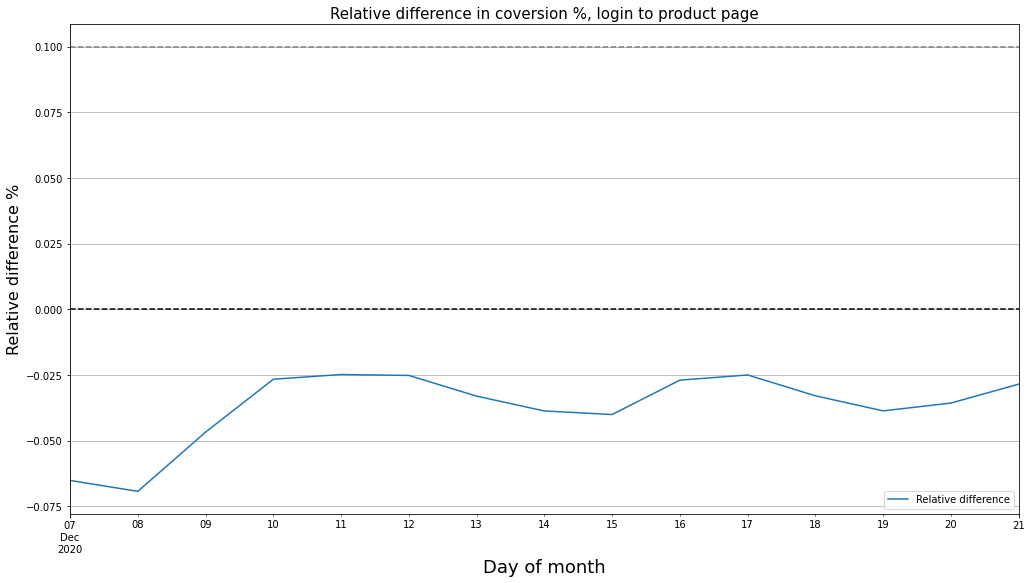

In [38]:
merged_cum_conversions.plot(x = 'date', y = 'login_page_relative', figsize=(17,9), grid = True, label = 'Relative difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('Relative difference in coversion %, login to product page', fontsize = 15)
plt.xlabel('Day of month', fontsize=18)
plt.ylabel('Relative difference %', fontsize=16)
plt.show()

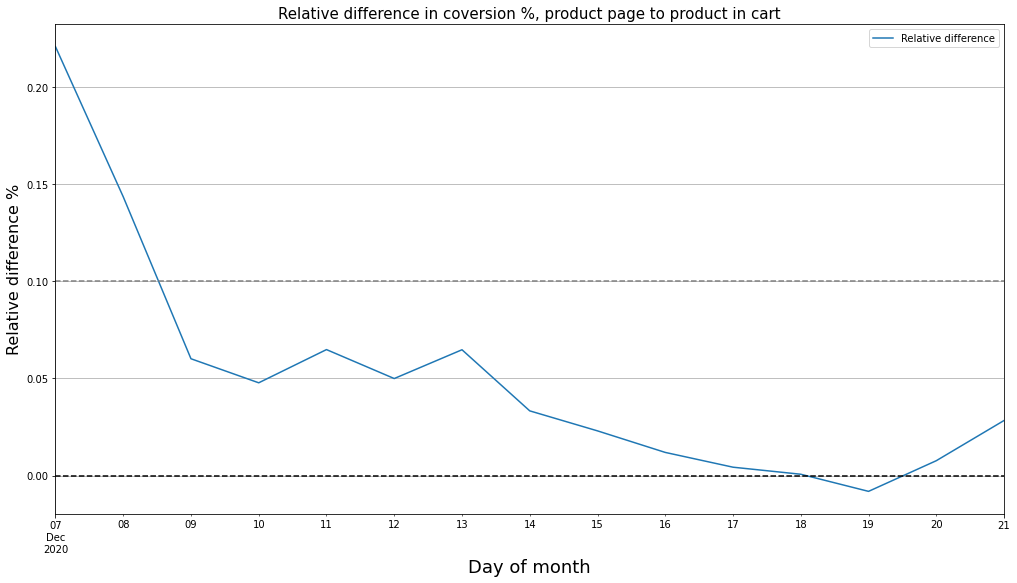

In [39]:
merged_cum_conversions.plot(x = 'date', y = 'page_cart_relative', figsize=(17,9), grid = True, label = 'Relative difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('Relative difference in coversion %, product page to product in cart', fontsize = 15)
plt.xlabel('Day of month', fontsize=18)
plt.ylabel('Relative difference %', fontsize=16)
plt.show()

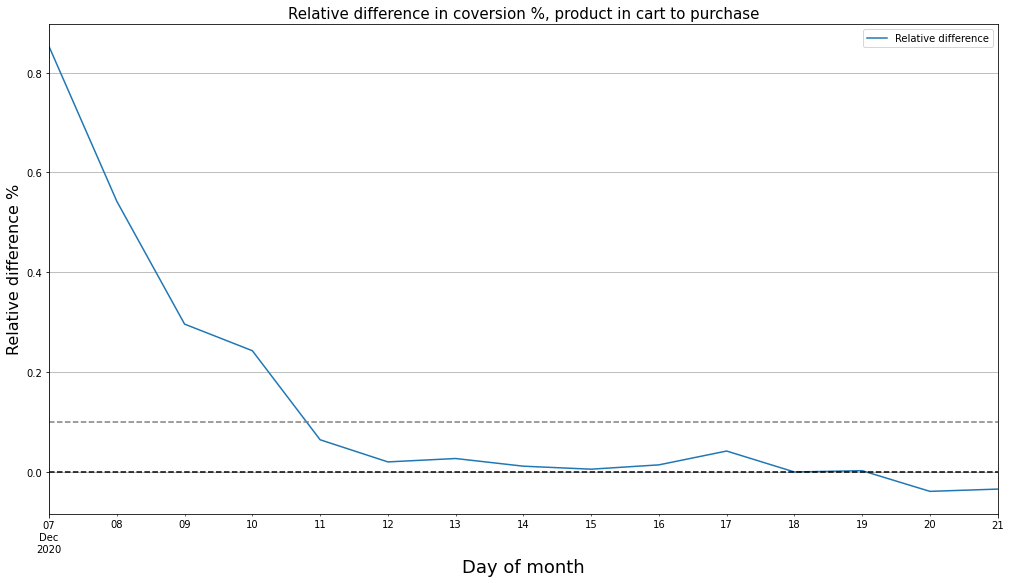

In [40]:
merged_cum_conversions.plot(x = 'date', y = 'cart_purchase_relative', figsize=(17,9), grid = True, label = 'Relative difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('Relative difference in coversion %, product in cart to purchase', fontsize = 15)
plt.xlabel('Day of month', fontsize=18)
plt.ylabel('Relative difference %', fontsize=16)
plt.show()

**In the relative difference in conversion, In the first stage group A has an adventage. In the other two, there's an adventage for group B only at the begining of the test. Later the difference stablize very close to zero.**

## A/B test

**In order to make sure the proportions of the two samples are equal, I will perform Z-test,  statistical test to determine whether two population means are different when the variances are known and the sample size is large.**

### Testing proportions

In [41]:
def z_test(a_success, b_success, a_trials, b_trials):
    alpha = .05 # significance level
    
    successes = np.array([a_success, b_success])
    trials = np.array([a_trials, b_trials])

    # success proportion in the first group:
    p1 = successes[0]/trials[0]

    # success proportion in the second group:
    p2 = successes[1]/trials[1]

    # success proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # the difference between the datasets' proportions
    difference = p1 - p2 

    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different") 

**Created a function in order to perform the z-test for each stage in the funnel.**

**H0: There is no statistically significant difference in proportion between the groups.**

**H1: There is a statistically significant difference in proportion between the groups.**

#### Login -> Product page

In [42]:
z_test(a_cumulative.loc[14, 'a_product_page_cumulative'],
       b_cumulative.loc[14, 'b_product_page_cumulative'],
       a_cumulative.loc[14, 'a_login_cumulative'],
       b_cumulative.loc[14, 'b_login_cumulative'])

p-value:  0.04592153486974904
Rejecting the null hypothesis: there is a significant difference between the proportions


#### Product page -> Product in cart

In [43]:
z_test(a_cumulative.loc[14, 'a_product_cart_cumulative'],
       b_cumulative.loc[14, 'b_product_cart_cumulative'],
       a_cumulative.loc[14, 'a_product_page_cumulative'],
       b_cumulative.loc[14, 'b_product_page_cumulative'])

p-value:  0.4105213665414782
Failed to reject the null hypothesis: there is no reason to consider the proportions different


#### Product in cart -> Purchase

In [44]:
z_test(a_cumulative.loc[14, 'a_purchase_cumulative'],
       b_cumulative.loc[14, 'b_purchase_cumulative'],
       a_cumulative.loc[14, 'a_product_cart_cumulative'],
       b_cumulative.loc[14, 'b_product_cart_cumulative'])

p-value:  0.5789567753802287
Failed to reject the null hypothesis: there is no reason to consider the proportions different


**We couldn't reject the null hypothesis in any of the stages, which means the samples were divided in good proportions and the graphs above aren't biased**

## Conclusion

**In order to increase number of users in each stage of our funnel, we have created some changes in the platform's recommendation system and launched an A/B to test the changes.**

**After receiving data regard various types of users, we have filtered the data, making sure we have 6000 participants that fall under the requierments for ouer test, users from EU region that were using the platform in specific dates**

**In the test, we have compared the daily conversion % for each stage, number of total daily events and number of daily events by user, cumulative revenue and average purchase size.**

**We couldn't find any definite advantage for any of the groups.**

**After that, made sure the proportions of the two samples have no significant difference, in order to make sure the samples were divided correctly, and found there are no significant differences in proportion in any of the stages, which means the samples are good and the test was performed correctly.**

**Note that because the tests were performed in dates close to christmas and new years eve, the resaults are only relevant to this time of the year and might be different in dates that aren't close to any major holiday.**

**In conclusion, we couldn't find advantage for the changes. We can't reccomend implemention of the changes for all users, but we suggest trying the test at a different time of the year**